### Recession Model Prediction: Model Comparison 

#### Author: Christina Lv 


In [214]:
#pip install yfinance
#pip install quandl
#pip install plotly 

In [215]:
import pandas as pd 
import numpy as np 
import quandl 
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt 

import plotly as plotly
import plotly.graph_objs as go
import plotly.express as px

In [216]:
#! pip install quandl
import quandl
quandl.ApiConfig.api_key = 'AtPuHRXs-rLGozrAYSKk'

#### Part 1: Retrieve Data - Predictive Variables

*1. Recession inferred by GDP*

*2. Fed funds rate*

*3. Unemployment rate*

*4. CPI: proxy for inflation*

*5 & 6. 10-year and 3-month Treasury Bond Yield*

In [217]:
recession_data = quandl.get("FRED/USRECQP", collapse="monthly") 
fed_funds_data = quandl.get("FRED/FEDFUNDS", collapse="monthly") 
unemploy_data = quandl.get("FRED/UNEMPLOY", collapse="monthly")
cpi_data = quandl.get("RATEINF/CPI_USA", collapse="monthly") 

ten_year = quandl.get("FRED/DGS10", collapse="daily") #10-Year Treasury Constant Maturity Rate
three_month = quandl.get("FRED/DTB3", collapse="daily") #3-month treasury bill - secondary market rate 

#### recession data 

NBER based Recession Indicators for the United States from the Peak through the Period preceding the Trough, +1 or 0, Quarterly, Not Seasonally Adjusted

A value of 1 is a recessionary period, while a value of 0 is an expansionary period. For this time series, the recession begins the first day of the period of the peak and ends on the last day of the period before the trough. For more options on recession shading, see the notes and links below.


In [218]:
recession_data.head(3)

Value
Date             
1854-10-31    0.0
1855-01-31    0.0
1855-04-30    0.0

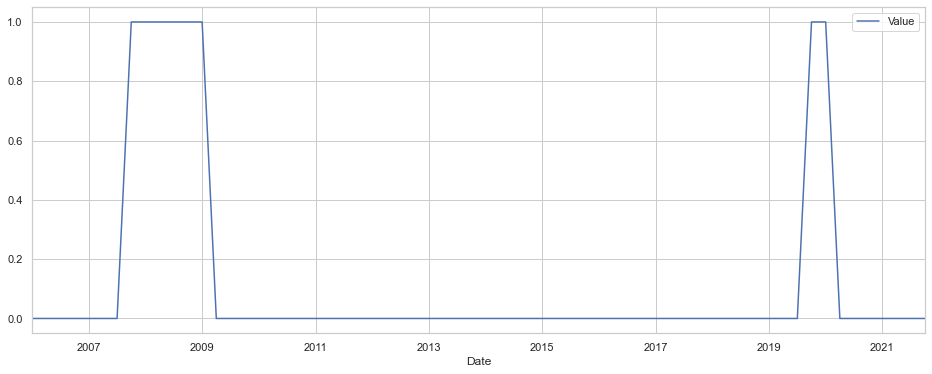

In [219]:
recession_data['2006-01-31':].plot(figsize = (16, 6));

#### Federal Funds Effective Rate (%)

Federal Funds Effective Rate, Percent, Monthly, Not Seasonally Adjusted

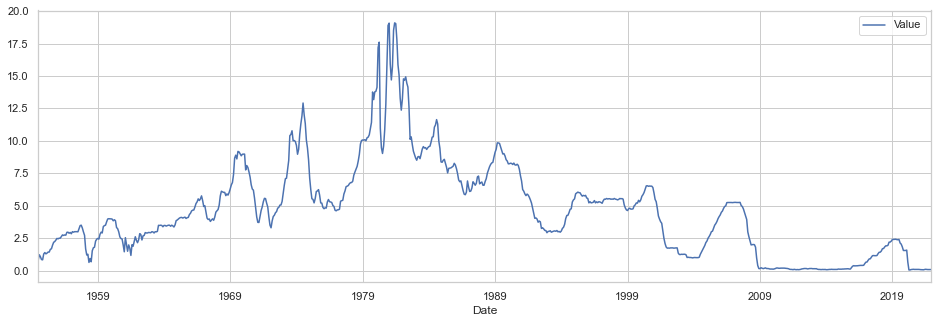

In [220]:
fed_funds_data.plot(figsize = (16, 5));

#### Unemployment Rate

$\color{red}{Question:}$ It is not unemployment rate (https://fred.stlouisfed.org/series/UNRATE). Could not find it online.

In [221]:
unemploy_data.head(3)

Value
Date              
1948-01-31  2034.0
1948-02-29  2328.0
1948-03-31  2399.0

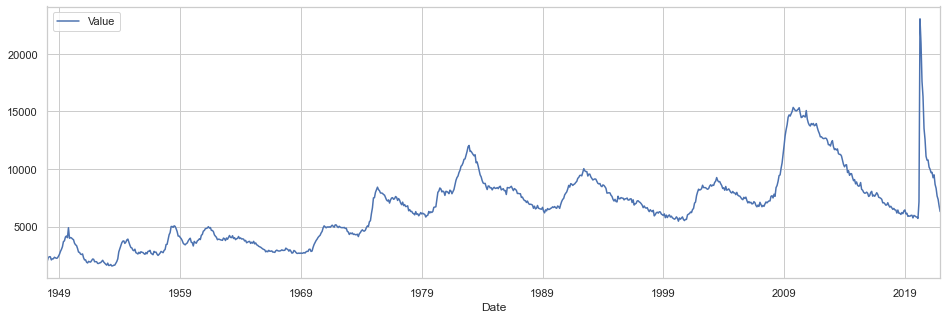

In [222]:
unemploy_data.plot(figsize = (16, 5));

#### CPI 

In [223]:
cpi_data.tail(3)

Value
Date               
2021-10-31  276.589
2021-11-30  277.948
2021-12-31  278.802

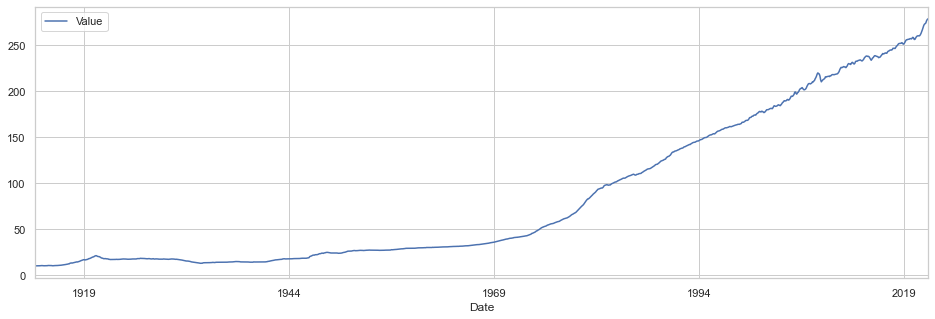

In [224]:
cpi_data.plot(figsize = (16, 5));

#### 10-Year Treasury Constant Maturity Rate

Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity (Daily) 

In [225]:
#for some days, data is missing
ten_year.tail(15)

Value
Date             
2021-12-29   1.55
2021-12-30   1.52
2021-12-31   1.52
2022-01-03   1.63
2022-01-04   1.66
2022-01-05   1.71
2022-01-06   1.73
2022-01-07   1.76
2022-01-10   1.78
2022-01-11   1.75
2022-01-12   1.74
2022-01-13   1.70
2022-01-14   1.78
2022-01-18   1.87
2022-01-19   1.83

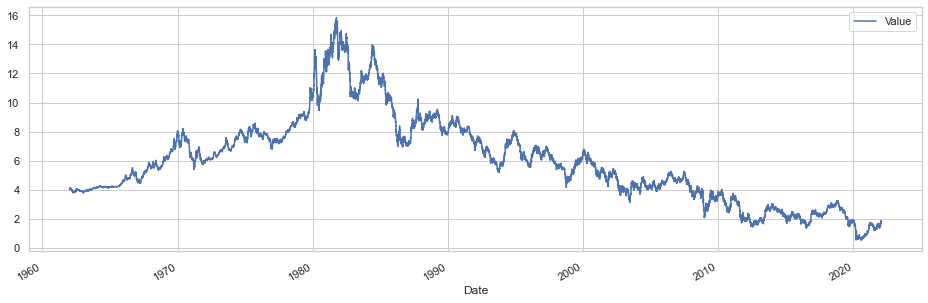

In [226]:
ten_year.plot(figsize = (16, 5));

#### 3-Month Treasury Bill Secondary Market Rate

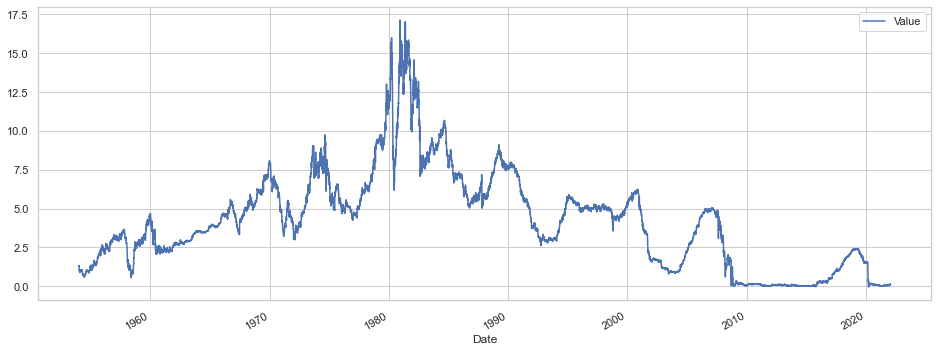

In [227]:
three_month.plot(figsize = (16, 6));

### Dataset 

In [228]:
data = pd.DataFrame()
data['fed_funds'] = fed_funds_data.Value
data['unemploy'] = unemploy_data.Value
data['cpi'] = cpi_data.Value
data['recession'] = recession_data.Value
data['3_month'] = three_month.Value
data['10YR'] = ten_year.Value
data

fed_funds  unemploy      cpi  recession  3_month  10YR
Date                                                              
1954-07-31       0.80    3659.0   26.900        0.0      NaN   NaN
1954-08-31       1.22    3854.0   26.900        NaN     1.05   NaN
1954-09-30       1.07    3927.0   26.800        NaN     0.99   NaN
1954-10-31       0.85    3666.0   26.800        0.0      NaN   NaN
1954-11-30       0.83    3402.0   26.800        NaN     1.01   NaN
...               ...       ...      ...        ...      ...   ...
2021-08-31       0.09    8339.0  273.567        NaN     0.04  1.30
2021-09-30       0.08    7666.0  274.310        NaN     0.04  1.52
2021-10-31       0.08    7375.0  276.589        0.0      NaN   NaN
2021-11-30       0.08    6802.0  277.948        NaN     0.05  1.43
2021-12-31       0.08    6319.0  278.802        NaN     0.06  1.52

[810 rows x 6 columns]

In [229]:
data['recession'].isna().sum()

540

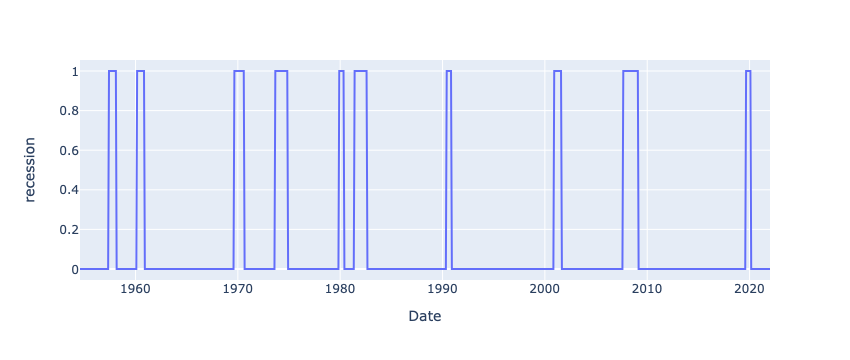

In [230]:
data["recession"] = data["recession"].fillna(method='bfill').fillna(method='ffill')
px.line(data, x= data.index, y='recession')

In [231]:
data.head()

fed_funds  unemploy   cpi  recession  3_month  10YR
Date                                                           
1954-07-31       0.80    3659.0  26.9        0.0      NaN   NaN
1954-08-31       1.22    3854.0  26.9        0.0     1.05   NaN
1954-09-30       1.07    3927.0  26.8        0.0     0.99   NaN
1954-10-31       0.85    3666.0  26.8        0.0      NaN   NaN
1954-11-30       0.83    3402.0  26.8        0.0     1.01   NaN

In [232]:
data.columns

Index(['fed_funds', 'unemploy', 'cpi', 'recession', '3_month', '10YR'], dtype='object')

#### Part 2: Data Transformation

*1. Recession inferred by GDP*

*2. Fed funds rate*

*3. Unemployment rate*: lagging indicator 

*4. CPI: proxy for inflation*

*5. Term Spread*

In [233]:
#Specify log differential function
def log_diff(v): 
    log_diff = np.log(v/v.shift(1))
    return log_diff 

In [234]:
data["yield_spread"] = (data['10YR'] - data['3_month']) #Calculate yield spread by taking the difference
data["fedfunds"] = data["fed_funds"].diff() 
data["unemploy_rate"] = log_diff(data["unemploy"])
data["cpi_index"] =  log_diff(data["cpi"])

In [235]:
#Robobank Reference: https://research.rabobank.com/publicationservice/download/publication/token/8Wsu7NXGcHfF4ZkWAkjg
data['adjusted_yield'] = (data["yield_spread"] - 2.616 + 0.808 * np.log(data['3_month'] + 1))

In [236]:
#Drop raw data after transformations are made
data = data.drop(['fed_funds','unemploy','cpi', '10YR', '3_month'], axis=1)

In [237]:
data.shape

(810, 6)

In [238]:
data = data[data['yield_spread'].notna()]

In [239]:
data.shape  #~40% of data is removed; many months are missing 

(503, 6)

In [240]:
data

recession  yield_spread  fedfunds  unemploy_rate  cpi_index  \
Date                                                                      
1962-01-31        0.0          1.37     -0.18      -0.023251   0.000000   
1962-02-28        0.0          1.29      0.22      -0.052829   0.003328   
1962-04-30        0.0          1.12     -0.07      -0.003833   0.003317   
1962-05-31        0.0          1.20     -0.42      -0.011070   0.000000   
1962-07-31        0.0          1.18      0.03      -0.006525   0.003306   
...               ...           ...       ...            ...        ...   
2021-06-30        0.0          1.40      0.02       0.026771   0.009248   
2021-08-31        0.0          1.26     -0.01      -0.039041   0.002064   
2021-09-30        0.0          1.48     -0.01      -0.084148   0.002712   
2021-11-30        0.0          1.38      0.00      -0.080879   0.004901   
2021-12-31        0.0          1.46      0.00      -0.073656   0.003068   

            adjusted_yield  
Date                        
1962-01-31       -0.182342  
1962-02-28       -0.266686  
1962-04-30       -0.430179  
1962-05-31       -0.358867  
1962-07-31       -0.344661  
...                    ...  
2021-06-30       -1.176578  
2021-08-31       -1.324310  
2021-09-30       -1.104310  
2021-11-30       -1.196578  
2021-12-31       -1.108919  

[503 rows x 6 columns]

$\color{red}{Question:}$ Should we aggregate yield spread by month (e.g., mean)?

$\color{red}{TODO:}$ (1) Group daily yield data (3 months and 10 yr yield) by mean value or use other aggregation method (e.g., choose value at the end of the month). (2) Merge aggregated monthly yield data with `data` dataframe containing monthly data for recession, fed funds, unemployment rate, and cpi. 

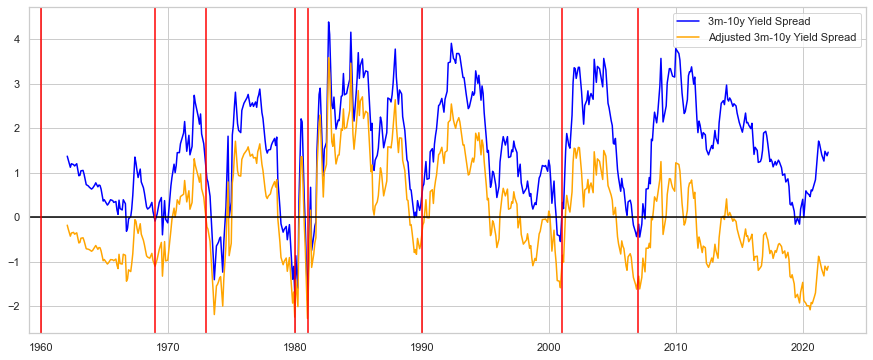

In [241]:
#Visualize the comparison between adjusted yield spread and 3m-10y yield spread
import datetime as dt
import seaborn as sns


sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))
plt.plot(data["yield_spread"], color='blue', label='3m-10y Yield Spread')
plt.plot(data['adjusted_yield'], color='orange', label='Adjusted 3m-10y Yield Spread')
plt.legend()

plt.axhline(0, color='black')

years = [1960, 1969, 1973, 1980, 1981, 1990, 2001, 2007]

for year in years:
    plt.axvline(dt.datetime(year, 1, 1), color='red')

### Part 3: New NBER Dates

In [242]:
#NBERt,t+12, equals one if there is an NBER recession starting at any time in the 12 months that follow the observed independent variables, and zero otherwise.

from datetime import date, timedelta

new_recession = []
for index, row in data.iterrows():
    if (index >= date(2020,12,31)): # NOTE: remember to update this date so it is always 12 month earlier than the latest month in data
        break
    new_value = 0
    for index2, row2 in data.iterrows():
        if (index2 > index) and ((index2 - index).days <= 365):
            if (row2['recession'] > 0.0):
                new_value = 1
    new_recession.append(new_value)        

In [243]:
for i in range(8):
    new_recession.append(0)

$\color{red}{Question:}$ I don't think appending zeros is correct? It implies that we know that in the next 12 months we won't have recession, which we cannot claim. 

$\color{red}{TODO:}$ Refactor the code to avoid populating manually the last values for new_recession with zeroes. 

In [244]:
len(new_recession)

503

In [245]:
data['adjusted_recession'] = new_recession

In [247]:
data.tail()

recession  yield_spread  fedfunds  unemploy_rate  cpi_index  \
Date                                                                      
2021-06-30        0.0          1.40      0.02       0.026771   0.009248   
2021-08-31        0.0          1.26     -0.01      -0.039041   0.002064   
2021-09-30        0.0          1.48     -0.01      -0.084148   0.002712   
2021-11-30        0.0          1.38      0.00      -0.080879   0.004901   
2021-12-31        0.0          1.46      0.00      -0.073656   0.003068   

            adjusted_yield  adjusted_recession  
Date                                            
2021-06-30       -1.176578                   0  
2021-08-31       -1.324310                   0  
2021-09-30       -1.104310                   0  
2021-11-30       -1.196578                   0  
2021-12-31       -1.108919                   0

### New Part 4: Model Testing 

In [248]:
data = data.reset_index()

In [249]:
data

Date  recession  yield_spread  fedfunds  unemploy_rate  cpi_index  \
0   1962-01-31        0.0          1.37     -0.18      -0.023251   0.000000   
1   1962-02-28        0.0          1.29      0.22      -0.052829   0.003328   
2   1962-04-30        0.0          1.12     -0.07      -0.003833   0.003317   
3   1962-05-31        0.0          1.20     -0.42      -0.011070   0.000000   
4   1962-07-31        0.0          1.18      0.03      -0.006525   0.003306   
..         ...        ...           ...       ...            ...        ...   
498 2021-06-30        0.0          1.40      0.02       0.026771   0.009248   
499 2021-08-31        0.0          1.26     -0.01      -0.039041   0.002064   
500 2021-09-30        0.0          1.48     -0.01      -0.084148   0.002712   
501 2021-11-30        0.0          1.38      0.00      -0.080879   0.004901   
502 2021-12-31        0.0          1.46      0.00      -0.073656   0.003068   

     adjusted_yield  adjusted_recession  
0         -0.182342                   0  
1         -0.266686                   0  
2         -0.430179                   0  
3         -0.358867                   0  
4         -0.344661                   0  
..              ...                 ...  
498       -1.176578                   0  
499       -1.324310                   0  
500       -1.104310                   0  
501       -1.196578                   0  
502       -1.108919                   0  

[503 rows x 8 columns]

In [250]:
# Convert Month into Datetime
data['Date']=pd.to_datetime(data['Date'])
data.set_index('Date',inplace=True)

In [251]:
X = data.drop(['adjusted_recession','recession','yield_spread'],axis=1)
y = data["adjusted_recession"]

In [252]:
X

fedfunds  unemploy_rate  cpi_index  adjusted_yield
Date                                                          
1962-01-31     -0.18      -0.023251   0.000000       -0.182342
1962-02-28      0.22      -0.052829   0.003328       -0.266686
1962-04-30     -0.07      -0.003833   0.003317       -0.430179
1962-05-31     -0.42      -0.011070   0.000000       -0.358867
1962-07-31      0.03      -0.006525   0.003306       -0.344661
...              ...            ...        ...             ...
2021-06-30      0.02       0.026771   0.009248       -1.176578
2021-08-31     -0.01      -0.039041   0.002064       -1.324310
2021-09-30     -0.01      -0.084148   0.002712       -1.104310
2021-11-30      0.00      -0.080879   0.004901       -1.196578
2021-12-31      0.00      -0.073656   0.003068       -1.108919

[503 rows x 4 columns]

In [254]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


clfs = {"Gaussian": GaussianNB(),
       "SVM": SVC(kernel='rbf', probability=True),
       "Random Forest": RandomForestClassifier(max_depth=15, 
                                                      n_estimators=200, 
                                                      class_weight = "balanced_subsample", 
                                                      random_state=42)}

In [253]:
X_train, y_train =  (X.loc["1962-01-31":"2006-01-31"], y.loc["1962-01-31":"2006-01-31"])
X_test_withNA, y_test_withNA =  (X.loc["2006-01-31":], y.loc["2006-01-31":])

In [262]:
X_train.shape

(369, 4)

In [270]:
X_train.shape[0]/X.shape[0] # train data 73%

0.7335984095427436

In [274]:
X_test_withNA

fedfunds  unemploy_rate  cpi_index  adjusted_yield
Date                                                          
2006-01-31      0.13      -0.029982   0.007593       -1.097891
2006-02-28      0.20       0.016845   0.002015       -1.197096
2006-03-31      0.10      -0.015713   0.005521       -0.895631
2006-05-31      0.15      -0.019859   0.004951       -0.824053
2006-06-30      0.05       0.003004   0.001973       -0.905957
...              ...            ...        ...             ...
2021-06-30      0.02       0.026771   0.009248       -1.176578
2021-08-31     -0.01      -0.039041   0.002064       -1.324310
2021-09-30     -0.01      -0.084148   0.002712       -1.104310
2021-11-30      0.00      -0.080879   0.004901       -1.196578
2021-12-31      0.00      -0.073656   0.003068       -1.108919

[135 rows x 4 columns]

$\color{red}{Question:}$ Why the last 8 rows are removed?

In [272]:
y_test = y_test_withNA[:-8]
y_test

Date
2006-01-31    0
2006-02-28    0
2006-03-31    0
2006-05-31    0
2006-06-30    0
             ..
2020-06-30    0
2020-07-31    0
2020-08-31    0
2020-09-30    0
2020-11-30    0
Name: adjusted_recession, Length: 127, dtype: int64

In [273]:
X_test = X_test_withNA[:-8]
X_test

fedfunds  unemploy_rate  cpi_index  adjusted_yield
Date                                                          
2006-01-31      0.13      -0.029982   0.007593       -1.097891
2006-02-28      0.20       0.016845   0.002015       -1.197096
2006-03-31      0.10      -0.015713   0.005521       -0.895631
2006-05-31      0.15      -0.019859   0.004951       -0.824053
2006-06-30      0.05       0.003004   0.001973       -0.905957
...              ...            ...        ...             ...
2020-06-30      0.03      -0.172854   0.005457       -1.996077
2020-07-31      0.01      -0.078379   0.005045       -2.086368
2020-08-31      0.01      -0.185371   0.003148       -1.921677
2020-09-30     -0.01      -0.072631   0.001392       -1.948989
2020-11-30      0.00      -0.030881  -0.000611       -1.793815

[127 rows x 4 columns]

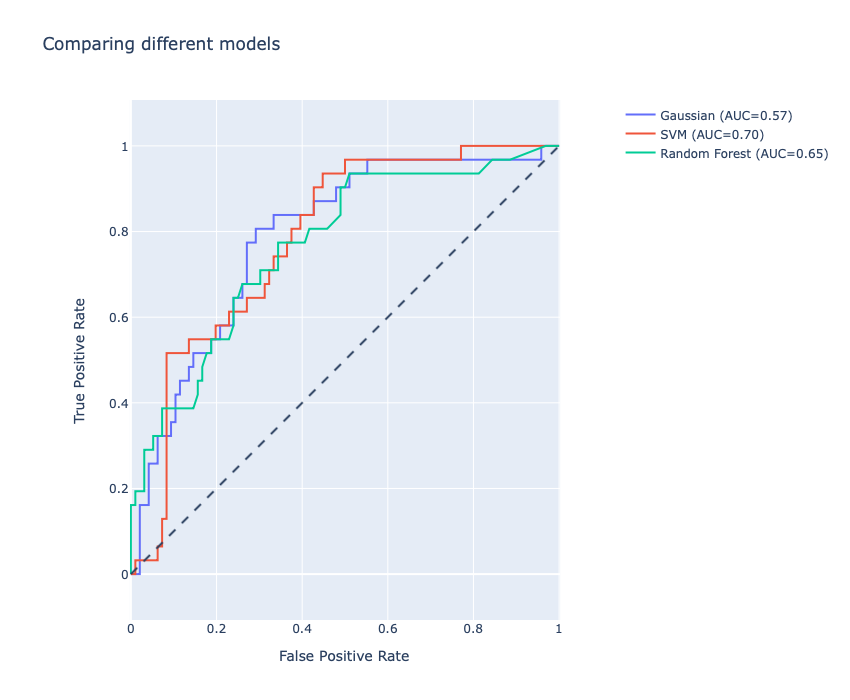

In [275]:
fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

for name, clf in clfs.items(): 
    clf.fit(X_train, y_train)
    y_pred= clf.predict(X_test) 
    fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test, clf.predict(X_test))

    name = f"{name} (AUC={auc:.2f})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=900, height=700
)
fig.update_layout(title_text="Comparing different models")
fig.show()

In [276]:
model = SVC(kernel='rbf', probability=True).fit(X_train, y_train)
predictions = model.predict(X_test)
score = accuracy_score(y_test,predictions)
report = classification_report(y_test,predictions)
print(score)
print(report)

0.8110236220472441
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        96
           1       0.65      0.48      0.56        31

    accuracy                           0.81       127
   macro avg       0.75      0.70      0.72       127
weighted avg       0.80      0.81      0.80       127



In [283]:
model.classes_


array([0, 1])

In [284]:
plot_proba = pd.DataFrame()
plot_proba['recession_proba'] = model.predict_proba(X_test)[:,1]

In [285]:
len(plot_proba)

127

In [286]:
plot_proba = pd.DataFrame()
plot_proba['recession_proba'] = model.predict_proba(X_test_withNA)[:,1]

The figure generated below shows the 12-month-look-ahead probability of recession. As observed, significant surge of recession probability appears in the year of 2007, which corresponds to the then upcoming recession in 2008.

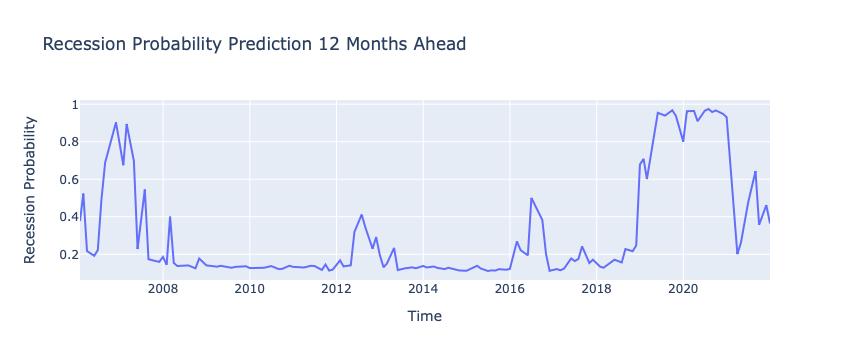

In [287]:
fig = go.Figure()
fig.add_scatter(x= X_test_withNA.index, y=plot_proba["recession_proba"], mode='lines',name="Prediction Results")


fig.update_layout(

xaxis_title='Time',
yaxis_title='Recession Probability'
)

fig.update_layout(title_text="Recession Probability Prediction 12 Months Ahead")
fig.show()

In [290]:
to_save = X_test_withNA.copy()

In [291]:
to_save['predicted_probability'] = model.predict_proba(X_test_withNA)[:,1]

In [292]:
to_save.head()

fedfunds  unemploy_rate  cpi_index  adjusted_yield  \
Date                                                             
2006-01-31      0.13      -0.029982   0.007593       -1.097891   
2006-02-28      0.20       0.016845   0.002015       -1.197096   
2006-03-31      0.10      -0.015713   0.005521       -0.895631   
2006-05-31      0.15      -0.019859   0.004951       -0.824053   
2006-06-30      0.05       0.003004   0.001973       -0.905957   

            predicted_probability  
Date                               
2006-01-31               0.376786  
2006-02-28               0.523258  
2006-03-31               0.216779  
2006-05-31               0.191401  
2006-06-30               0.221826

In [293]:
to_save = to_save.drop(['fedfunds', 'unemploy_rate', 'cpi_index', 'adjusted_yield'], axis=1)

In [294]:
to_save

predicted_probability
Date                             
2006-01-31               0.376786
2006-02-28               0.523258
2006-03-31               0.216779
2006-05-31               0.191401
2006-06-30               0.221826
...                           ...
2021-06-30               0.475809
2021-08-31               0.643016
2021-09-30               0.356731
2021-11-30               0.461502
2021-12-31               0.364011

[135 rows x 1 columns]

This "to_save" data frame contains the predicted probability of whether there will be a recession in the upcoming 12 months at the given date. For example, a row with "date" being 2006-01-31 and "predicted probability" of 0.3959 means that, the model predicts between 2006-01-31 and 2007-01-31 the probability of having a recesion is 39.59%

In [295]:
to_save.to_csv('out_sample_recession_probability.csv')

$\color{red}{Question:}$ Do we need in sample predictions? 

### In sample predictiom

In [45]:
in_sample_predictions = model.predict(X_train)
in_sample_score = accuracy_score(y_train,in_sample_predictions)
in_sample_report = classification_report(y_train,in_sample_predictions)
print(in_sample_score)
print(in_sample_report)

0.8401084010840109
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       283
           1       0.86      0.37      0.52        86

    accuracy                           0.84       369
   macro avg       0.85      0.68      0.71       369
weighted avg       0.84      0.84      0.81       369



In [46]:
X_train

fedfunds  unemploy_rate  cpi_index  adjusted_yield
Date                                                          
1962-01-31     -0.18      -0.023251   0.000000       -0.182342
1962-02-28      0.22      -0.052829   0.003328       -0.266686
1962-04-30     -0.07      -0.003833   0.003317       -0.430179
1962-05-31     -0.42      -0.011070   0.000000       -0.358867
1962-07-31      0.03      -0.006525   0.003306       -0.344661
...              ...            ...        ...             ...
2005-08-31      0.24      -0.008271   0.005105       -0.831551
2005-09-30      0.12       0.027925   0.012146       -0.536110
2005-10-31      0.16      -0.013328   0.002010       -0.653549
2005-11-30      0.22       0.015048  -0.008065       -0.708521
2006-01-31      0.13      -0.029982   0.007593       -1.097891

[369 rows x 4 columns]

In [47]:
in_sample_to_save = X_train.copy()

In [48]:
in_sample_to_save['predicted_probability'] = model.predict_proba(X_train)[:,1]

In [49]:
in_sample_to_save = in_sample_to_save.drop(['fedfunds', 'unemploy_rate', 'cpi_index', 'adjusted_yield'], axis=1)

In [50]:
# save from year 1980 and hopefully it is early enough, feel free to adjust
in_sample_to_save[150::]

predicted_probability
Date                             
1980-01-31               0.760102
1980-02-29               0.932041
1980-03-31               0.918012
1980-04-30               0.230049
1980-06-30               0.654890
...                           ...
2005-08-31               0.223491
2005-09-30               0.134168
2005-10-31               0.148318
2005-11-30               0.179125
2006-01-31               0.374884

[219 rows x 1 columns]

In [51]:
in_sample_to_save.to_csv('in_sample_recession_probability.csv')